In [1]:
import cubewalkers as cw
import cupy as cp
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
IMPORT_RULES_FROM_FILES = True
cc_models_dir = './models/cell_collective/'
if IMPORT_RULES_FROM_FILES:
    from os import listdir
    
    sync_models = {}
    for fname in listdir(cc_models_dir):
        with open(cc_models_dir+fname) as rulefile:
            name = fname.strip('.txt')
            rules = rulefile.read()
            sync_models[name]=cw.Model(rules)
else:
    from cana.datasets.bio import load_all_cell_collective_models
    def cell_collective_models():
        return {BN.name:cw.Model(cw.conversions.network_rules_from_cana(BN)) 
                for BN in load_all_cell_collective_models()}
    sync_models = cell_collective_models()
    for name,model in sync_models.items():
        with open(cc_models_dir+name+'.txt','w') as rulefile:
            rulefile.write(model.rules)

total_models = len(sync_models)
async_models = deepcopy(sync_models)

In [3]:
def simulate_models(models, sync=True, W_max=125000):
    for model_idx, (model_name, model) in enumerate(sorted(models.items())):
        model.n_walkers = W_max
        N = model.n_variables
        T = 100
        
        model.n_time_steps = T

        print(f"Simulating Model {model_name} . . .")
        if sync:
            model.simulate_ensemble(averages_only=False,
                                    maskfunction=cw.update_schemes.synchronous,
                                    threads_per_block=(16, 16))
        else:
            model.simulate_ensemble(averages_only=False,
                                    maskfunction=cw.update_schemes.asynchronous,
                                    threads_per_block=(16, 16))
            
        
        
        print(f"Progress: {(model_idx+1)}/{total_models}")

In [4]:
simulate_models(sync_models,sync=True)

Simulating Model Apoptosis Network . . .
Progress: 1/74
Simulating Model Arabidopsis thaliana Cell Cycle . . .
Progress: 2/74
Simulating Model Aurora Kinase A in Neuroblastoma . . .
Progress: 3/74
Simulating Model B bronchiseptica and T retortaeformis coinfection . . .
Progress: 4/74
Simulating Model B cell differentiation . . .
Progress: 5/74
Simulating Model BT474 Breast Cell Line Long-term ErbB Network . . .
Progress: 6/74
Simulating Model BT474 Breast Cell Line Short-term ErbB Network . . .
Progress: 7/74
Simulating Model Bordetella bronchiseptica . . .
Progress: 8/74
Simulating Model Bortezomib Responses in U266 Human Myeloma Cells . . .
Progress: 9/74
Simulating Model Budding Yeast Cell Cycle . . .
Progress: 10/74
Simulating Model Budding Yeast Cell Cycle 2009 . . .
Progress: 11/74
Simulating Model CD4 T cell signaling . . .
Progress: 12/74
Simulating Model CD4+ T Cell Differentiation and Plasticity . . .
Progress: 13/74
Simulating Model CD4+ T cell Differentiation . . .
Progress

In [5]:
sync_models['Apoptosis Network'].trajectories.shape

(101, 41, 125000)

In [12]:
pts = {}
for tf in [0,10,100]:
    pts[tf] = []
    for w in [1,2,5,10,20,50,100,200,500,1000,2000,5000]:
        for model in sync_models.values():
            stds = cp.std(cp.array([cp.mean(model.trajectories[tf,:,i*w:(i*w+w)],axis=1) for i in range(50)]),axis=0)
            arr = [(w,v) for v in stds.get()]
            pts[tf]+=arr
    

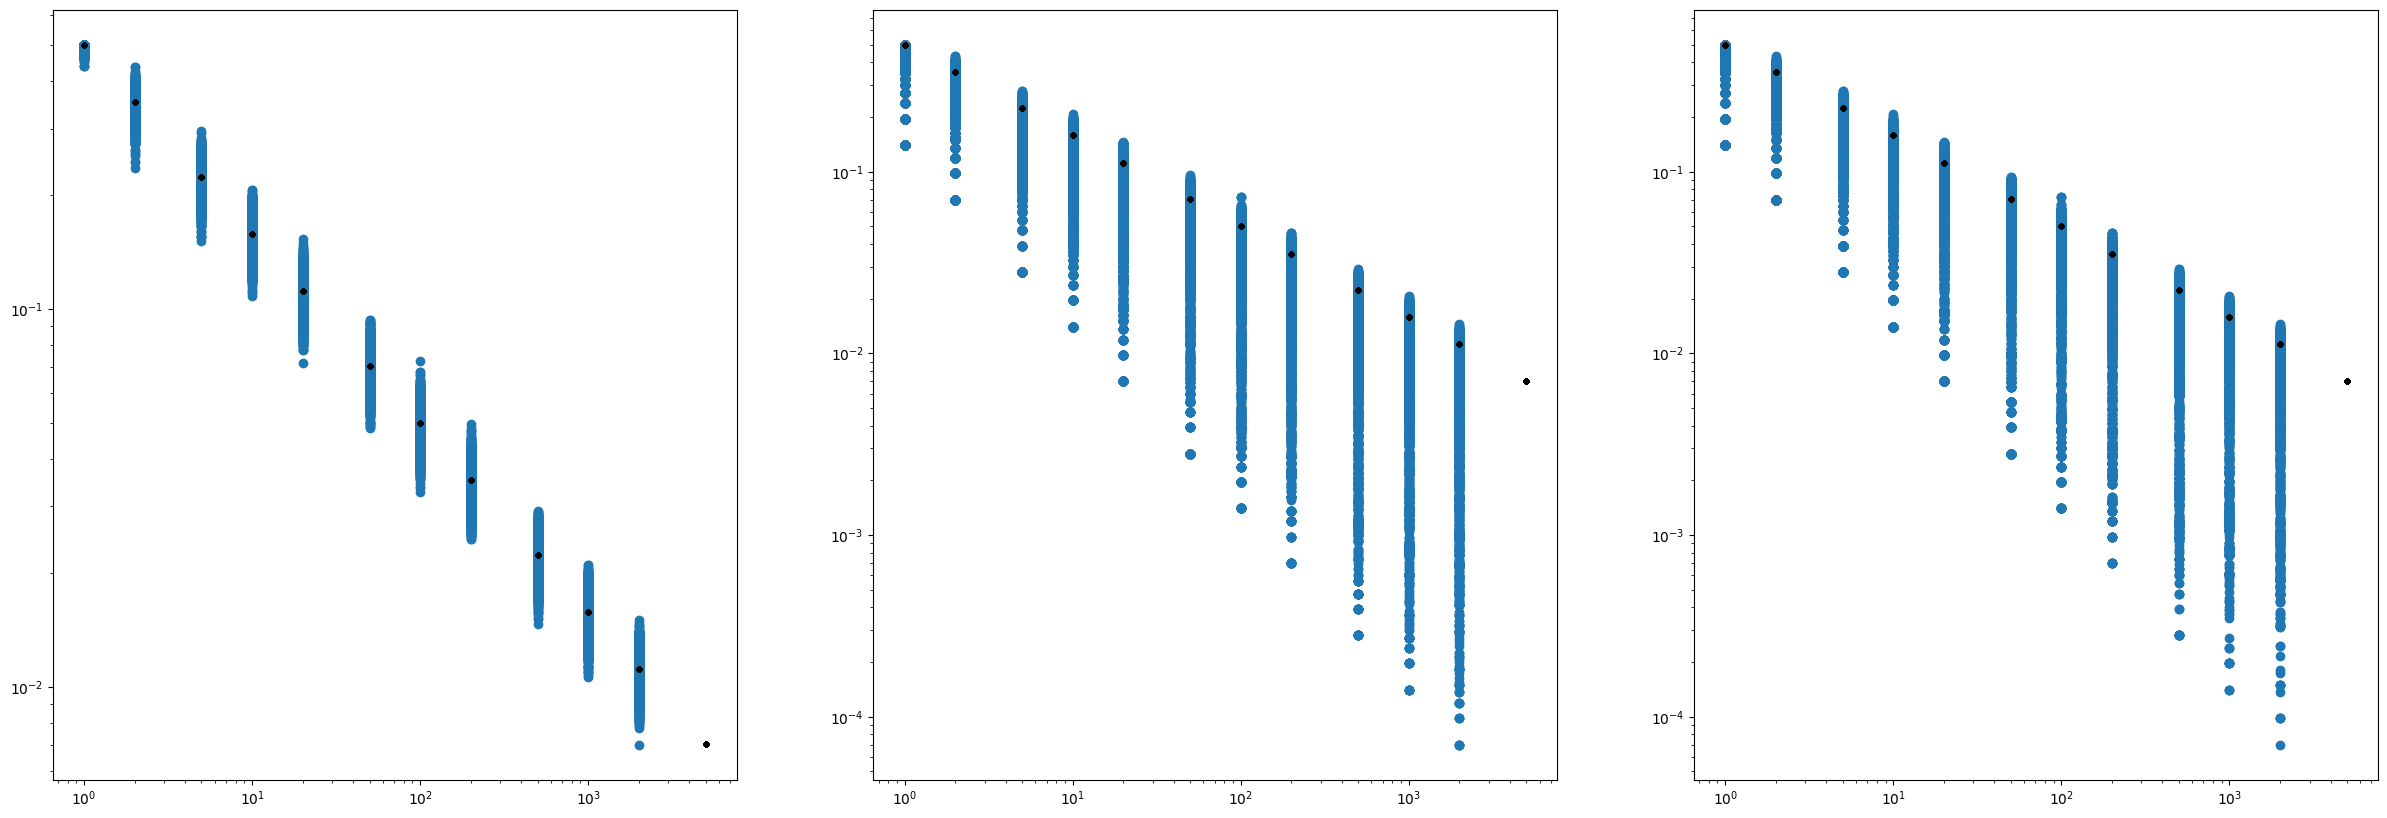

In [23]:
fig,ax = plt.subplots(1,3,figsize=(30,10))
fig.set_facecolor('white')

for ind,tf in enumerate([0,10,100]):
    x,y = zip(*pts[tf])
    ax[ind].scatter(x,y)
    ax[ind].plot(x,[0.5/xx**0.5 for xx in x],'k--')
    ax[ind].set_xscale('log')
    ax[ind].set_yscale('log')
